In [ ]:
#import spotipy
#from spotipy.oauth2 import SpotifyOAuth
#pip install spotipy --upgrade
#spotify = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='a6204bb2c7d44e98af9ab2c2d6518a09', client_secret='df3f58e414574e79b104f6e2ce25fd1c', redirect_uri='http://localhost/', scope = "user-read-recently-played"))

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def get_listening_history(filename):
    """
    filename: (str) the path to the .json file containing the spotify listening history
    
    Loads in the listening history as a pandas dataframe
    Adds columns to the dataframe based on the information in the 'endTime' column of the df:
    'Date' contains the year-month-day date that the song was played
    'Time' contains the hour-minute-second time that the song finished playing
    'Month-Year' contains the year-month date that the song was played
    """
    df = pd.read_json(filename)
    df['Date'] = pd.to_datetime(df['endTime']).dt.date
    df['Time'] = pd.to_datetime(df['endTime']).dt.time
    df['Month-Year'] = pd.to_datetime(df['endTime']).dt.to_period('m')
    return df

def song_play_frequencies(df, dates, date_column_name):
    """
    df = (dataframe) the name of the dataframe with the listening history
    dates = (list) the range of periods to use (days or months)
    date_column_name = (str) the name of the time period column to use ('Date' or 'Month-Year')
    returns a new dataframe with the number of times each song was played within the time period specified (each day or month)
    """
    song_freqs_df = pd.DataFrame()
    for date in dates:
        value_counts_df = df[df[date_column_name]==date][['trackName','artistName']].value_counts().to_frame().reset_index().rename(columns={0:'Number of Plays'})
        value_counts_df[date_column_name] = date
        song_freqs_df = song_freqs_df.append(value_counts_df)
    song_freqs_df.reset_index(drop=True)
    return song_freqs_df

def merge_songs(song_to_merge, original_song):
    """
    song_to_merge = (str) the alternate name for the song (will be replaced)
    original song = (str) the name of the song that you want to display (what to replace with)
    Use if the same song exists in two different versions on Spotify and is being counted separately but you want them to be counted as one
    e.g. the original version and extended version of a song
    """
    df.replace(song_to_merge,original_song,inplace=True)
    return df

def print_top_songs_per_month(df, months, n=5):
    """
    df = (dataframe) the name of the dataframe with the listening history
    months = (list) the range of month-year pairs to use
    n (optional) = (int) the number of top songs to display for each month. default is set to 5.
    Prints out the top n songs for each month with the name of the song, name of the artist, and the number of times the song was played in that month.
    """
    for month in months:
        months_songs = df[df["Month-Year"] == month]
        freq = months_songs[['trackName','artistName']].value_counts()
        print(month)
        print(freq.head(n))
        print()
        
def top_songs_per_month(df, months, n=5):
    """
    df = (dataframe) the name of the dataframe with the listening history
    months = (list) the range of month-year pairs to use
    n (optional) = (int) the number of top songs to display for each month. default is set to 5.
    Returns a dataframe containing the top n songs for each month with the name of the song, name of the artist, number of times the song was played in the month, and month.
    """
    top_songs_df = pd.DataFrame()
    for month in months:
        months_songs = df[df["Month-Year"] == month]
        freq = months_songs[['trackName','artistName']].value_counts().to_frame().reset_index().rename(columns={0:'Number of Plays'})
        top_n = freq.head(n)
        top_n['Month-Year'] = month
        top_songs_df = top_songs_df.append(top_n)
    return top_songs_df

def plot_top_songs_over_time(top_songs_df, monthly_song_freqs_df, dates, date_column_name):
    
    top_songs = top_songs_df['trackName'].unique()
    
    all_plays_of_top_songs_df = pd.DataFrame()
    for song in top_songs:
        all_plays = monthly_song_freqs_df[monthly_song_freqs_df['trackName']==song]
        all_plays_of_top_songs_df = all_plays_of_top_songs_df.append(all_plays)
    
    plt.figure(figsize=(20,15))
    pd.plotting.register_matplotlib_converters()

    for song in top_songs:
        one_song_freqs = all_plays_of_top_songs_df[all_plays_of_top_songs_df['trackName']==song]
        freq_list = []
        for date in dates:
            if (one_song_freqs[date_column_name]==date).any():
                that_day = one_song_freqs[one_song_freqs[date_column_name]==date]
                freq_list.append(int(sum(that_day['Number of Plays'])))
            else:
                freq_list.append(0)
        dates_and_freqs_df = pd.DataFrame(data=freq_list, index=dates)
        dates_and_freqs_df.index = dates_and_freqs_df.index.to_timestamp()
        plt.plot(dates_and_freqs_df, label=song)
        plt.legend()
     
    plt.savefig('top_song_per_month_over_time.png')
    plt.show()
    

In [3]:
df = get_listening_history('MyData/StreamingHistory0.json')
df = merge_songs("MONTERO (Call Me By Your Name) - SATAN'S EXTENDED VERSION",'MONTERO (Call Me By Your Name)')

In [4]:
days = df['Date'].unique()
months = df['Month-Year'].unique()

In [5]:
top_10_songs_overall = df['trackName'].value_counts()
top_10_artists_overall = df['artistName'].value_counts()
top_10_songs_overall.head(10), top_10_artists_overall.head(10)

(MONTERO (Call Me By Your Name)    102
 good 4 u                           70
 drivers license                    67
 deja vu                            46
 SUN GOES DOWN                      45
 The Night We Met                   43
 Happier Than Ever                  43
 traitor                            42
 Angel With A Shotgun               40
 brutal                             39
 Name: trackName, dtype: int64,
 Lil Nas X              417
 Olivia Rodrigo         393
 Billie Eilish          349
 Twenty One Pilots      129
 Panic! At The Disco     95
 Fall Out Boy            77
 Maccabeats              69
 Cardi B                 65
 Lil Dicky               48
 Andrew Garfield         47
 Name: artistName, dtype: int64)

In [6]:
daily_song_freqs_df = song_play_frequencies(df, days, 'Date')
monthly_song_freqs_df = song_play_frequencies(df, months, 'Month-Year')

In [7]:
songs = daily_song_freqs_df['trackName'].unique()

In [8]:
print_top_songs_per_month(df, months)

2021-01
trackName             artistName    
The Night We Met      Lord Huron        4
Angel With A Shotgun  The Cab           4
drivers license       Olivia Rodrigo    4
WITHOUT YOU           The Kid LAROI     2
YEET                  YEET              2
dtype: int64

2021-02
trackName                                                 artistName                        
That Would Be Enough - Instrumental                       Original Broadway Cast of Hamilton    6
Prologue                                                  John Williams                         6
Total Eclipse of the Heart - Karaoke                      Best Instrumentals                    6
7 Years (Instrumental Version)                            The O'Neill Brothers Group            5
Bohemian Rhapsody (Piano Verison) [Made Famous By Queen]  Acoustic Hits                         5
dtype: int64

2021-03
trackName                                                                                                             

In [9]:
top_songs_df = top_songs_per_month(df, months, n=1)
top_songs_df

/var/folders/yf/2mykrtbj3cxf8byxf7kttk700000gn/T/ipykernel_14986/3333307909.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n['Month-Year'] = month


,trackName,artistName,Number of Plays,Month-Year
0,The Night We Met,Lord Huron,4,2021-01
0,That Would Be Enough - Instrumental,Original Broadway Cast of Hamilton,6,2021-02
0,Chad Gadya (One Kid),Jay Levy,4,2021-03
0,MONTERO (Call Me By Your Name),Lil Nas X,33,2021-04
0,good 4 u,Olivia Rodrigo,21,2021-05
0,good 4 u,Olivia Rodrigo,20,2021-06
0,good 4 u,Olivia Rodrigo,11,2021-07
0,Happier Than Ever,Billie Eilish,31,2021-08
0,MONTERO (Call Me By Your Name),Lil Nas X,9,2021-09
0,Hard to Be the Bard,Christian Borle,3,2021-10


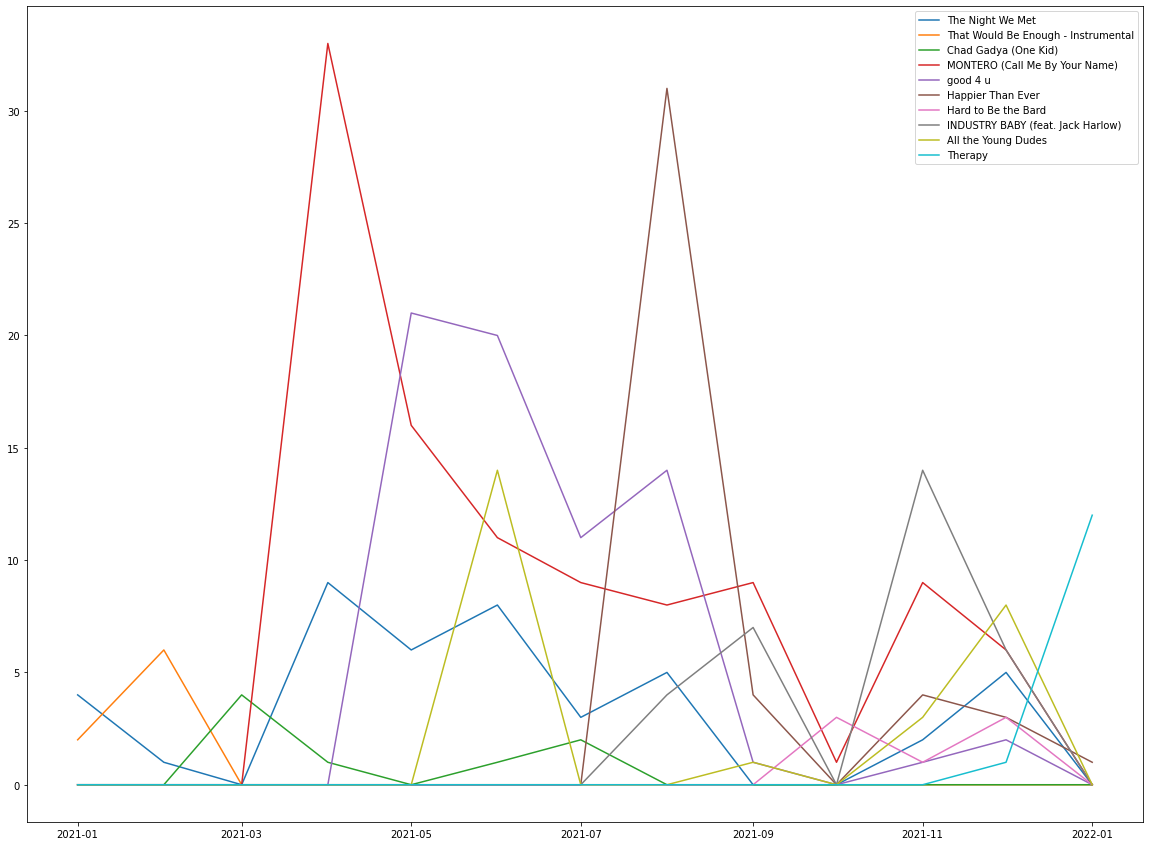

In [18]:
plot_top_songs_over_time(top_songs_df, monthly_song_freqs_df, months, 'Month-Year')